***Issue#4 - Traversal of the space of cross-validation folds.***

Fix for #4: https://github.com/mozilla/PRESC/issues/4

In this notebook, we will do the experiment with cross-validation folds and see how the accuracy of the model varies. We will use SVM classifier along with MinMax data Transformation and Hyperparameter tuning as per my notebook for issue #2.

I chose that settings because using transformation and hyperparameter tuning improved my results in my previous experiments for issue #2

***Steps***

1. Data Exploration and Outlier Fixing
2. Data Transformation
    - MinmaxScaler
3. Hyperparameter Tuning(GridCV)
    - I am using GridSearchCV function to find the optimal parameters i.e parameter tuning. I will be using rbf(Radial basis kernel). The optimal params value for c and gamma was based on this kaggle kernel (https://www.kaggle.com/rajansharma780/vehicle/kernels).
4. Training model using StratifiedKFold cross validation and see how the model accuracy differs based on the number of folds
    - Cross Validation: StratifiedKFold 
    - 10 passes ranging from 5-folds to 15-folds
5. Display result in tabular format

***References:***

1. https://scikit-learn.org
2. https://www.kaggle.com/rajansharma780/vehicle/kernels

In [1]:
# Ignore all the future warning and deprecation warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
pd.set_option("display.precision", 2) 

from issue4_helper import test_cross_validation, fix_outlier_with_boundary_value
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [2]:
# Read the data
df = pd.read_csv("../../datasets/vehicles.csv")

In [3]:
# Set Feature and Label Column
feature_cols = ['COMPACTNESS', 'CIRCULARITY', 'DISTANCE_CIRCULARITY', 'RADIUS_RATIO',
       'PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SCATTER_RATIO',
       'ELONGATEDNESS', 'PR.AXIS_RECTANGULARITY', 'MAX.LENGTH_RECTANGULARITY',
       'SCALED_VARIANCE_MAJOR', 'SCALED_VARIANCE_MINOR',
       'SCALED_RADIUS_OF_GYRATION', 'SKEWNESS_ABOUT_MAJOR',
       'SKEWNESS_ABOUT_MINOR', 'KURTOSIS_ABOUT_MAJOR']
label_col = ['Class']

**Exploratory Data Analysis**

In [4]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
COMPACTNESS,846.0,93.68,8.23,73.0,87.00,93.0,100.0,119.0
CIRCULARITY,846.0,44.86,6.17,33.0,40.00,44.0,49.0,59.0
DISTANCE_CIRCULARITY,846.0,82.09,15.77,40.0,70.00,80.0,98.0,112.0
RADIUS_RATIO,846.0,168.94,33.47,104.0,141.00,167.0,195.0,333.0
PR.AXIS_ASPECT_RATIO,846.0,61.69,7.89,47.0,57.00,61.0,65.0,138.0
MAX.LENGTH_ASPECT_RATIO,846.0,8.57,4.60,2.0,7.00,8.0,10.0,55.0
SCATTER_RATIO,846.0,168.84,33.24,112.0,146.25,157.0,198.0,265.0
ELONGATEDNESS,846.0,40.93,7.81,26.0,33.00,43.0,46.0,61.0
PR.AXIS_RECTANGULARITY,846.0,20.58,2.59,17.0,19.00,20.0,23.0,29.0
MAX.LENGTH_RECTANGULARITY,846.0,148.00,14.52,118.0,137.00,146.0,159.0,188.0


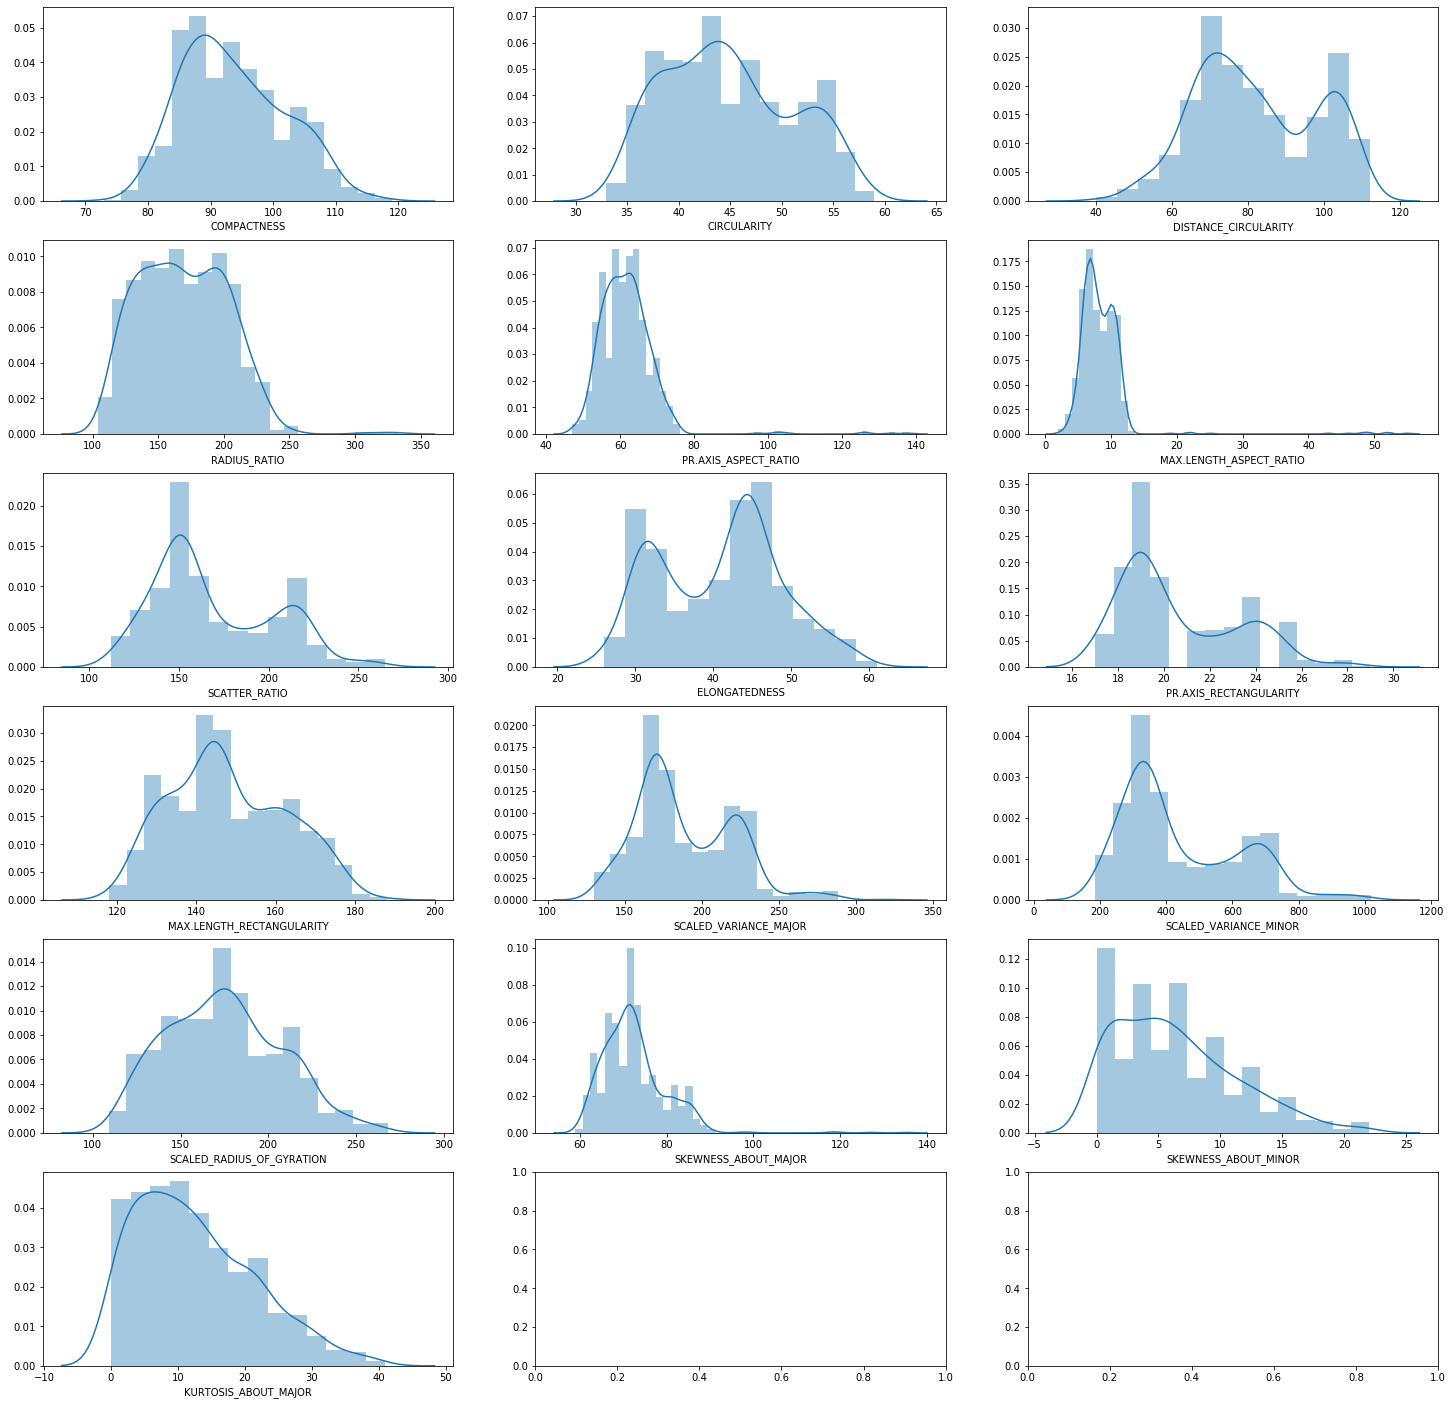

In [5]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25, 25))
for i, column in enumerate(feature_cols):
    sns.distplot(df[column],ax=axes[i//3,i%3])

In [6]:
df['Class'].unique()

array(['van', 'saab', 'bus', 'opel'], dtype=object)

**Data Insight**

The data looks clean as there are no null values out of total 846 entries. All of the fields are of integer types. The last column is the target value which will be used as label. There are four vehicle categories: 'van', 'saab', 'bus', 'opel'. This is multi-class classifcation problem.

From above statistics, Standard deviation(scatteredness) seems high for SCALED_VARIANCE_MINOR field. For other mean and standard deviation looks fine. And the distribution for each feature has many variations : unimodal, bimodal and multimodal.

There are few outliers in some features such as : MAX.LENGTH_ASPECT_RATIO, SKEWNESS_ABOUT_MAJOR.

Since we have outliers in our data, lets create boxplot graph to identify min, max values and outliers.

**Fixing Outliers**

Based on the above graph, these are the features/columns that have outliers:

1. RADIUS_RATIO
2. PR.AXIS_ASPECT_RATIO
3. MAX.LENGTH_ASPECT_RATIO
4. SCALED_VARIANCE_MAJOR
5. SCALED_VARIANCE_MINOR
6. SKEWNESS_ABOUT_MAJOR
7. SKEWNESS_ABOUT_MINOR
8. KURTOSIS_ABOUT_MAJOR

We will fix all the rows that have outliers by replacing outliers > max by max value(of that column/feature) because outliers in data can result in inaccurate models.

There are 51 rows with outliers out of 846 rows.

In [7]:
# Max value based on boxplot to filter outliers of 8 columns where outliers are identified. 
df_columns_with_outliers = pd.DataFrame([[255, 77, 13, 288, 980, 88, 19, 40]], columns=['RADIUS_RATIO', 
                                                                                'PR.AXIS_ASPECT_RATIO', 
                                                                                'MAX.LENGTH_ASPECT_RATIO', 
                                                                                'SCALED_VARIANCE_MAJOR', 
                                                                                'SCALED_VARIANCE_MINOR', 
                                                                                'SKEWNESS_ABOUT_MAJOR', 
                                                                                'SKEWNESS_ABOUT_MINOR', 
                                                                                'KURTOSIS_ABOUT_MAJOR'])

total_outliers = 0
for i, column in enumerate(df_columns_with_outliers.columns):
    total_outliers += df[column][df[column] > df_columns_with_outliers[column][0]].size
print('Out of {} rows {} Outliers '.format(len(df.index), total_outliers))

Out of 846 rows 51 Outliers 


In [8]:
# Outliers handling by replacing outliers by mean
df_new = fix_outlier_with_boundary_value(df, df_columns_with_outliers)

df_new.info()
df_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   COMPACTNESS                846 non-null    int64
 1   CIRCULARITY                846 non-null    int64
 2   DISTANCE_CIRCULARITY       846 non-null    int64
 3   RADIUS_RATIO               846 non-null    int64
 4   PR.AXIS_ASPECT_RATIO       846 non-null    int64
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    int64
 6   SCATTER_RATIO              846 non-null    int64
 7   ELONGATEDNESS              846 non-null    int64
 8   PR.AXIS_RECTANGULARITY     846 non-null    int64
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    int64
 10  SCALED_VARIANCE_MAJOR      846 non-null    int64
 11  SCALED_VARIANCE_MINOR      846 non-null    int64
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    int64
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    int64
 14  SKEWNESS_ABOUT_MINOR      

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,3
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,3
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,2
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,3
4,85,44,70,205,77,13,149,45,19,144,241,325,188,88,9,11,180,183,0


**Redrawing the plots to see the outliers again**

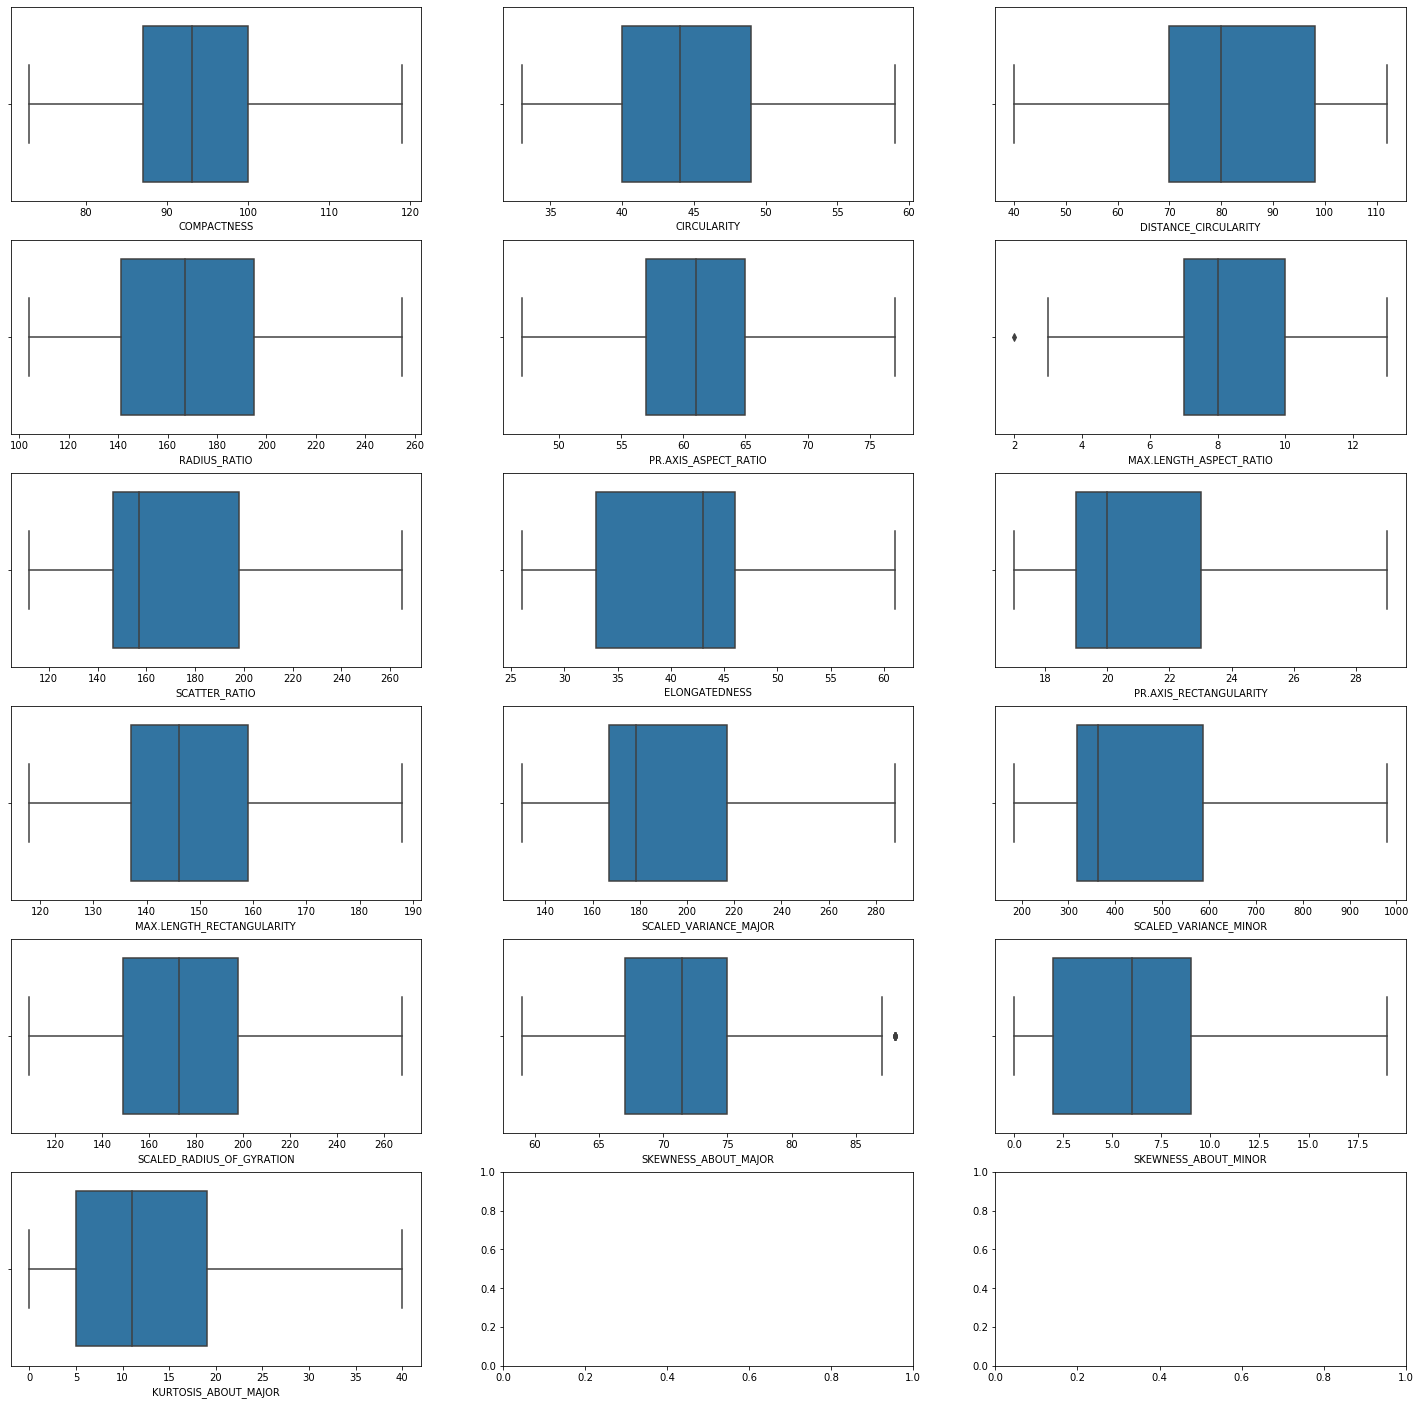

In [9]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25, 25))
for i, column in enumerate(feature_cols):
    sns.boxplot(df_new[column],ax=axes[i//3,i%3], dodge=False, whis=1.5)

**Post Outlier Fixing**

I did not remove the outlier instead I used the conservative approach. After outlier fix, the rows count are same. We can see no outliers in the above boxplot, except 2 outliers in two different columns.

**CROSS VALIDATION EXPERIMENT**

***==== Current Settings ====***
- Estimator: SVM
- Hyperparameter Tuning: 
    - GridSearchCV
    - Grid params referenced from this kaggle kernel https://www.kaggle.com/rajansharma780/vehicle/kernels
- Outlier fix: Replacing outliers greator than max values with the max value of the feature column
- Cross Validation: StratifiedKFold 
    - 10 passes ranging from 5-folds to 15-folds
- Display the result in the tabular format

***Stratified KFOLD CV***

I am using KStratified cross validation because it ensures that the percentage of each class in entire dataset is nearly equal or same within each fold

In [10]:
# Read X and Y values 
X_new = df_new[feature_cols]
y_new = df_new[label_col]

# Parameters for GridSearch 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 
    
estimator = GridSearchCV(SVC(), param_grid, refit = True, verbose = False)  

# StratifiedKFold CV
# Runs the training for multiple folds starting from 5 to 15 and returns the result in tabular format
result_df = test_cross_validation(estimator, X_new, y_new.values.ravel())
result_df

,K-Fold CV,Avg. Score
0,5,0.80
1,6,0.80
2,7,0.78
3,8,0.78
4,9,0.79
5,10,0.79
6,11,0.80
7,12,0.80
8,13,0.80
9,14,0.79


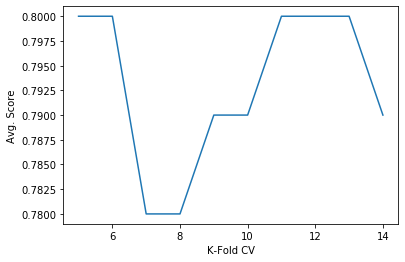

In [11]:
sns.lineplot(data=result_df, x='K-Fold CV', y='Avg. Score')

***Result***

Based on the above result, the choice of the number of folds does have some effect on the accuracy of the model. But the relation is neither positive nor negative.
